In [66]:
import pandas as pd
import warnings
warnings.filterwarnings('ignore')
import numpy as np
import nltk
import re
import matplotlib.pyplot as plt
from nltk.corpus import stopwords
from nltk.tokenize import word_tokenize
from sklearn.metrics import accuracy_score,precision_score,confusion_matrix,recall_score, f1_score, confusion_matrix, classification_report
from sklearn.feature_extraction.text import CountVectorizer
from sklearn.naive_bayes import MultinomialNB
from sklearn.model_selection import train_test_split
from sklearn.tree import DecisionTreeClassifier
from sklearn.linear_model import LogisticRegression, RidgeClassifier
from sklearn.metrics import roc_curve, roc_auc_score, precision_recall_curve
from yellowbrick.model_selection import LearningCurve, ValidationCurve
from sklearn.svm import SVC
from sklearn.ensemble import RandomForestClassifier, AdaBoostClassifier
from sklearn.multiclass import OneVsRestClassifier
from yellowbrick.classifier import ROCAUC, PrecisionRecallCurve
from sklearn.neighbors import KNeighborsClassifier
import time
from sklearn.model_selection import GridSearchCV, StratifiedKFold, LeaveOneOut, cross_val_score


In [3]:
data = pd.read_csv('train.csv')
data

,sms,label
0,"Go until jurong point, crazy.. Available only ...",0
1,Ok lar... Joking wif u oni...\n,0
2,Free entry in 2 a wkly comp to win FA Cup fina...,1
3,U dun say so early hor... U c already then say...,0
4,"Nah I don't think he goes to usf, he lives aro...",0
...,...,...
5569,This is the 2nd time we have tried 2 contact u...,1
5570,Will ü b going to esplanade fr home?\n,0
5571,"Pity, * was in mood for that. So...any other s...",0
5572,The guy did some bitching but I acted like i'd...,0


**Целью работы** является создание модели машинного обучения для классификации сообщений и спама.    
**Задача** подобрать оптимальную модель машинного обучения для классификации текстов, которая с наибольшей точностью распознает спам-сообщения.      
**Прикладное значение:** модель может быть использована в дальнейшем в различных мессенджерах и электронных почтах

**Описание датасета:**    
Набор данных для классификации сообщений. Датасет состоит из 5574 наблюдений - сообщений. Данные размечены на 2 категории - спам-сообщения('1') и не спам('0'). Этот датасет хорошо подходит для бинарной классификации текстов.

#Выведем общую информацию по данным в датасете:

In [4]:
data.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 5574 entries, 0 to 5573
Data columns (total 2 columns):
 #   Column  Non-Null Count  Dtype 
---  ------  --------------  ----- 
 0   sms     5574 non-null   object
 1   label   5574 non-null   int64 
dtypes: int64(1), object(1)
memory usage: 87.2+ KB


In [5]:
data.describe()

,label
count,5574.000000
mean,0.134015
std,0.340699
min,0.000000
25%,0.000000
50%,0.000000
75%,0.000000
max,1.000000


In [6]:
data.isnull().sum()

sms      0
label    0
dtype: int64

In [7]:
data.duplicated().sum()

403

Все ячейки в датасете являеются ненулевыми значениями. Однако в данных присутствуют дубликаты. В дальнейшем их наличие может привести к переобучению модели или влиять на метрики, поэтому целесоообразно их удалить.

In [8]:
data.drop_duplicates(subset=['sms'], inplace=True)

Выведем статистику по количеству спам и не-спам сообщений в датасете

In [9]:
print(data['label'].value_counts())

label
0    4518
1     653
Name: count, dtype: int64


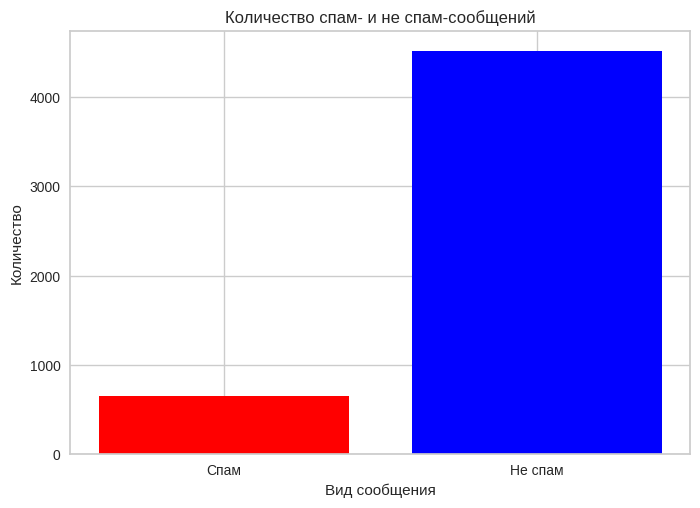

Количество спам-сообщений: 653
Количество не спам-сообщений: 4518
Всего сообщений: 5171


In [10]:
spam_count = sum(data.label==True)
non_spam_count = len(data) - spam_count
total_emails = data.shape[0]

categories = ['Спам', 'Не спам']
counts = [spam_count, non_spam_count]

plt.bar(categories, counts, color=['red', 'blue'])
plt.xlabel('Вид сообщения')
plt.ylabel('Количество')
plt.title('Количество спам- и не спам-сообщений')
plt.show()
print("Количество спам-сообщений:", spam_count)
print("Количество не спам-сообщений:", non_spam_count)
print("Всего сообщений:", total_emails)

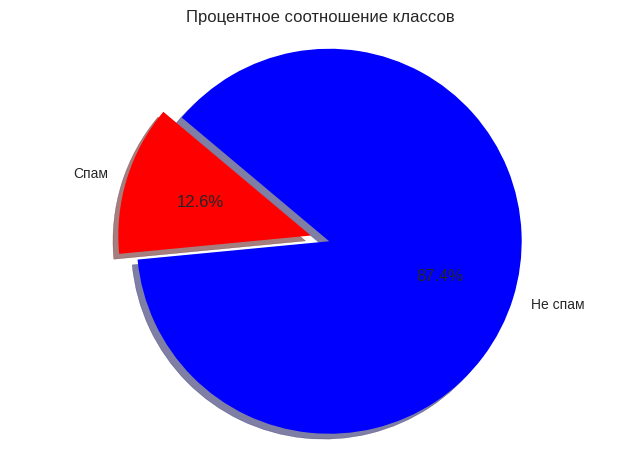

In [11]:
spam_percent = (spam_count / total_emails) * 100
non_spam_percent = (non_spam_count / total_emails) * 100
labels = 'Спам', 'Не спам'
sizes = [spam_percent, non_spam_percent]
colors = ['red', 'blue']
explode = (0.1, 0)
plt.pie(sizes, explode=explode, labels=labels, colors=colors, autopct='%1.1f%%', shadow=True, startangle=140)
plt.axis('equal')
plt.title('Процентное соотношение классов')
plt.show()

#Предобработка данных

Приведем все данные к одному регистру - нижнему и удалим знаки препинания для дальнейшей работы с датасетом

In [12]:
data.sms = data.sms.map(lambda t: re.sub(r'[^\w\s]', '', t.lower()))
data.sms = data.sms.map(lambda t: re.sub(r'[^\w\s]', '', t.lower()))

data

,sms,label
0,go until jurong point crazy available only in ...,0
1,ok lar joking wif u oni\n,0
2,free entry in 2 a wkly comp to win fa cup fina...,1
3,u dun say so early hor u c already then say\n,0
4,nah i dont think he goes to usf he lives aroun...,0
...,...,...
5569,this is the 2nd time we have tried 2 contact u...,1
5570,will ü b going to esplanade fr home\n,0
5571,pity was in mood for that soany other suggest...,0
5572,the guy did some bitching but i acted like id ...,0


In [13]:
nltk.download('punkt')
nltk.download('stopwords')

[nltk_data] Downloading package punkt to /root/nltk_data...
[nltk_data]   Unzipping tokenizers/punkt.zip.
[nltk_data] Downloading package stopwords to /root/nltk_data...
[nltk_data]   Unzipping corpora/stopwords.zip.


True

Токенизируем текст сообщений и удалим стоп-слова

In [14]:
def tokenize_and_remove_stopwords(text):
    tokens = word_tokenize(text)
    tokens = [word for word in tokens if word not in stopwords.words('english')]
    return ' '.join(tokens)

In [15]:
data['clean_txt'] = data['sms'].apply(tokenize_and_remove_stopwords)

In [16]:
data

,sms,label,clean_txt
0,go until jurong point crazy available only in ...,0,go jurong point crazy available bugis n great ...
1,ok lar joking wif u oni\n,0,ok lar joking wif u oni
2,free entry in 2 a wkly comp to win fa cup fina...,1,free entry 2 wkly comp win fa cup final tkts 2...
3,u dun say so early hor u c already then say\n,0,u dun say early hor u c already say
4,nah i dont think he goes to usf he lives aroun...,0,nah dont think goes usf lives around though
...,...,...,...
5569,this is the 2nd time we have tried 2 contact u...,1,2nd time tried 2 contact u u 750 pound prize 2...
5570,will ü b going to esplanade fr home\n,0,ü b going esplanade fr home
5571,pity was in mood for that soany other suggest...,0,pity mood soany suggestions
5572,the guy did some bitching but i acted like id ...,0,guy bitching acted like id interested buying s...


В модели sklearn.feature_extraction есть преобразователь CountVectorizer
с собственными методами лексемизации и нормализации. Метод fit этого преобразователя принимает итерируемую последовательность или список строк
или объектов файлов и создает словарь корпуса. Метод transform преобразует
каждый отдельный документ в разреженный массив, роль индексов в котором
играют кортежи с идентификаторами документов и лексем из словаря, а роль
значений — счетчики лексем.    
Преобразуем текст с помощью этого преобразователя и запишем его в переменную Х


In [17]:
vectorizer = CountVectorizer()
X = vectorizer.fit_transform(data['clean_txt'])

In [18]:
Y = data['label']

# Построение моделей классификации

Разобъём выборку на тестовую и обучающую выборки

In [91]:
X_train, X_test, y_train, y_test = train_test_split(X, Y, test_size=0.2)

Построим 7 моделей классификации:    


*   Naive Bayes
*   DecisionTreeClassifier
*   Support Vector Machine
*   RandomForest
*   KNeighboors
*   RidgeClassifier
*   AdaBoostClassifier









##Найвный Байессовский классификатор

In [148]:
naive_bayes = MultinomialNB()
start = time.time()
naive_bayes.fit(X_train, y_train)
end = time.time()
time_nb = end-start

In [108]:
time_nb

0.0058743953704833984

Выведем кривую обучения. На графике мы видим, что как такого переобучения и недообучения нет

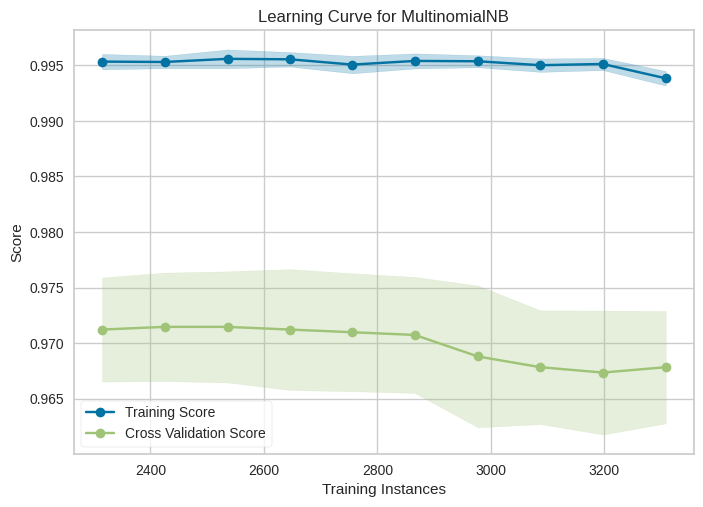

In [109]:
visualizer = LearningCurve(
     MultinomialNB(), scoring='accuracy', train_sizes=np.linspace(0.7, 1.0, 10)
).fit(X_train, y_train).show()

In [110]:
y_pred = naive_bayes.predict(X_test)
accuracy_nb = accuracy_score(y_test, y_pred)

Выведем метрики модели

In [111]:
accuracy_nb

0.9739130434782609

In [112]:
print(classification_report(y_test, y_pred))

              precision    recall  f1-score   support

           0       0.99      0.98      0.99       914
           1       0.86      0.93      0.89       121

    accuracy                           0.97      1035
   macro avg       0.92      0.96      0.94      1035
weighted avg       0.98      0.97      0.97      1035



Визульное изображение метрик:


ROC-кривая позволяет сравнить различные модели классификации, оценить их производительность и выбрать оптимальный порог для принятия решения о классификации в зависимости от конкретной задачи. Чем ближе кривая к левому верхнему углу, тем лучше производительность модели.    
PR-кривая позволяет оценить производительность классификатора в условиях несбалансированных классов, где точность и полнота играют важную роль. Чем ближе кривая к правому верхнему углу, тем лучше производительность модели.

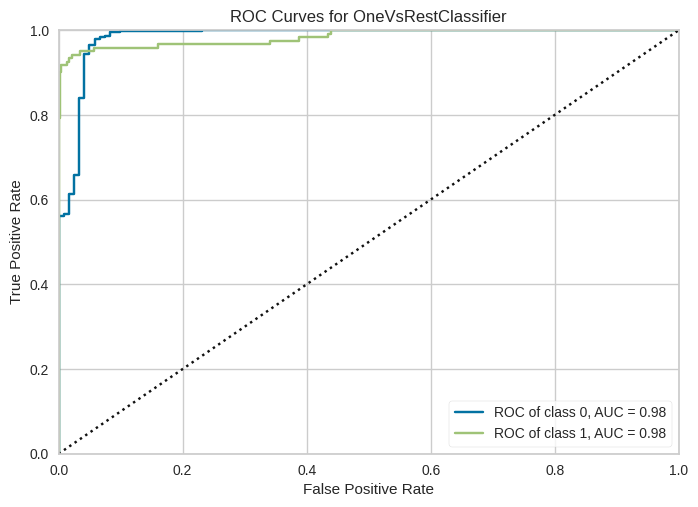

<Axes: title={'center': 'ROC Curves for OneVsRestClassifier'}, xlabel='False Positive Rate', ylabel='True Positive Rate'>

In [113]:
classifier = OneVsRestClassifier(MultinomialNB())

# Создаем объект для построения ROC-кривой
roc_auc_visualizer = ROCAUC(classifier, micro=False, macro=False, per_class=True)

#строим ROC-кривую
roc_auc_visualizer.fit(X_train, y_train)
roc_auc_visualizer.score(X_test, y_test)
roc_auc_visualizer.show()

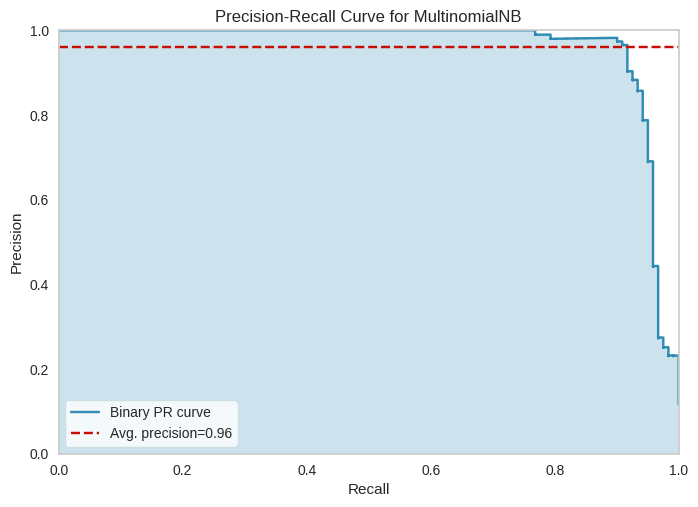

<Axes: title={'center': 'Precision-Recall Curve for MultinomialNB'}, xlabel='Recall', ylabel='Precision'>

In [114]:
prc_visualizer = PrecisionRecallCurve(naive_bayes)

prc_visualizer.fit(X_train, y_train)
prc_visualizer.score(X_test, y_test)
prc_visualizer.show()

##Дерево решений

In [115]:
decision_tree = DecisionTreeClassifier()
start = time.time()
decision_tree.fit(X_train, y_train)
end = time.time()
time_dt = end-start

Выведем метрики модели

In [116]:
y_pred = decision_tree.predict(X_test)
accuracy_tree = accuracy_score(y_test, y_pred)
accuracy_tree

0.9671497584541063

In [117]:
print(classification_report(y_test, y_pred))

              precision    recall  f1-score   support

           0       0.97      0.99      0.98       914
           1       0.91      0.79      0.85       121

    accuracy                           0.97      1035
   macro avg       0.94      0.89      0.92      1035
weighted avg       0.97      0.97      0.97      1035



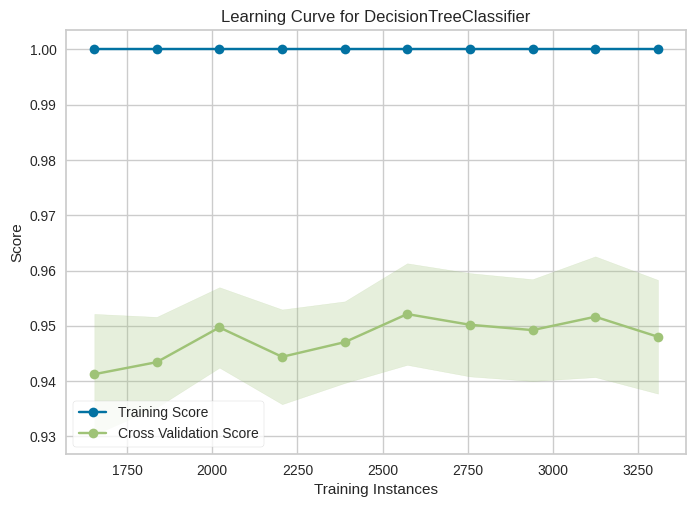

In [118]:
visualizer = LearningCurve(
    DecisionTreeClassifier(), scoring='accuracy', train_sizes=np.linspace(0.5, 1.0, 10)
).fit(X_train, y_train).show()

Визульное изображение метрик:


ROC-кривая позволяет сравнить различные модели классификации, оценить их производительность и выбрать оптимальный порог для принятия решения о классификации в зависимости от конкретной задачи. Чем ближе кривая к левому верхнему углу, тем лучше производительность модели.    
PR-кривая позволяет оценить производительность классификатора в условиях несбалансированных классов, где точность и полнота играют важную роль. Чем ближе кривая к правому верхнему углу, тем лучше производительность модели.

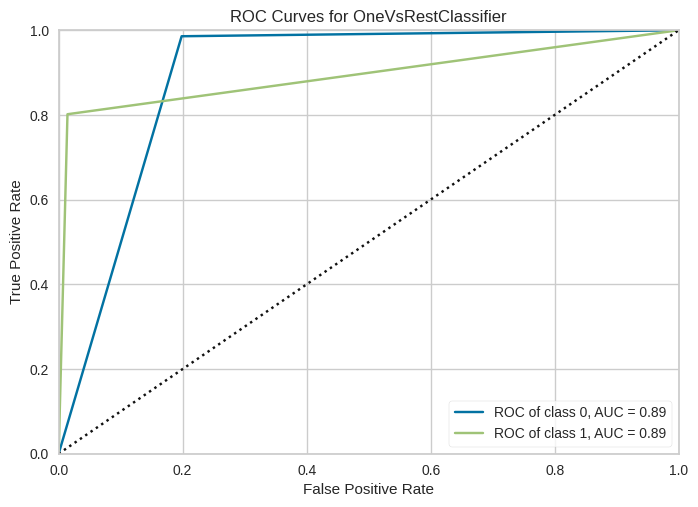

<Axes: title={'center': 'ROC Curves for OneVsRestClassifier'}, xlabel='False Positive Rate', ylabel='True Positive Rate'>

In [119]:
classifier = OneVsRestClassifier(DecisionTreeClassifier())

# Создаем объект для построения ROC-кривой
roc_auc_visualizer = ROCAUC(classifier, micro=False, macro=False, per_class=True)

#строим ROC-кривую
roc_auc_visualizer.fit(X_train, y_train)
roc_auc_visualizer.score(X_test, y_test)
roc_auc_visualizer.show()

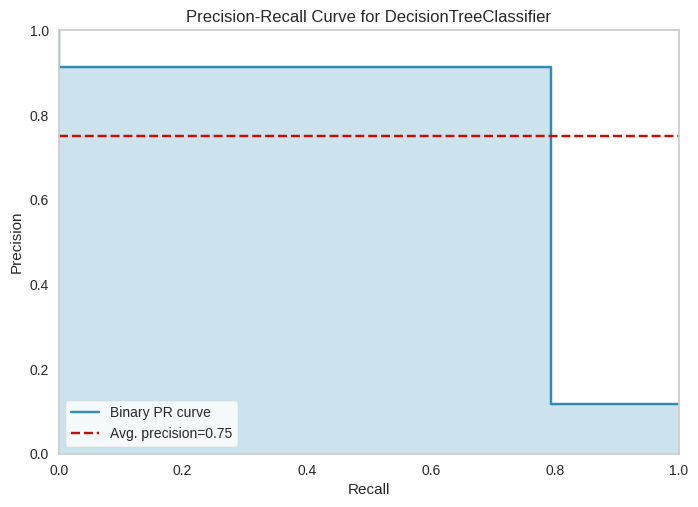

<Axes: title={'center': 'Precision-Recall Curve for DecisionTreeClassifier'}, xlabel='Recall', ylabel='Precision'>

In [120]:
prc_visualizer = PrecisionRecallCurve(decision_tree)

prc_visualizer.fit(X_train, y_train)
prc_visualizer.score(X_test, y_test)
prc_visualizer.show()

##Метод опорных векторов

In [149]:
svc = SVC()
start = time.time()
svc.fit(X_train, y_train)
end = time.time()
time_svc = end-start
y_pred = svc.predict(X_test)
accuracy_svc = accuracy_score(y_test, y_pred)
accuracy_svc

0.9777777777777777

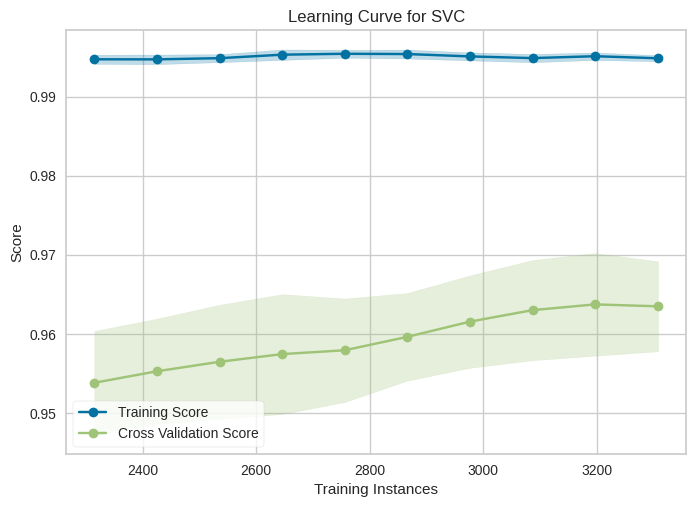

In [150]:
visualizer = LearningCurve(
    SVC(), scoring='accuracy', train_sizes=np.linspace(0.7, 1.0, 10)
).fit(X_train, y_train).show()

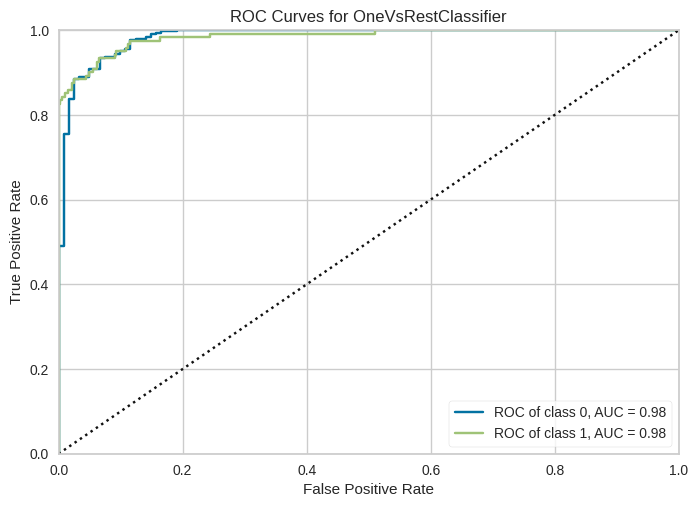

<Axes: title={'center': 'ROC Curves for OneVsRestClassifier'}, xlabel='False Positive Rate', ylabel='True Positive Rate'>

In [151]:
classifier = OneVsRestClassifier(SVC())

# Создаем объект для построения ROC-кривой
roc_auc_visualizer = ROCAUC(classifier, micro=False, macro=False, per_class=True)

#строим ROC-кривую
roc_auc_visualizer.fit(X_train, y_train)
roc_auc_visualizer.score(X_test, y_test)
roc_auc_visualizer.show()

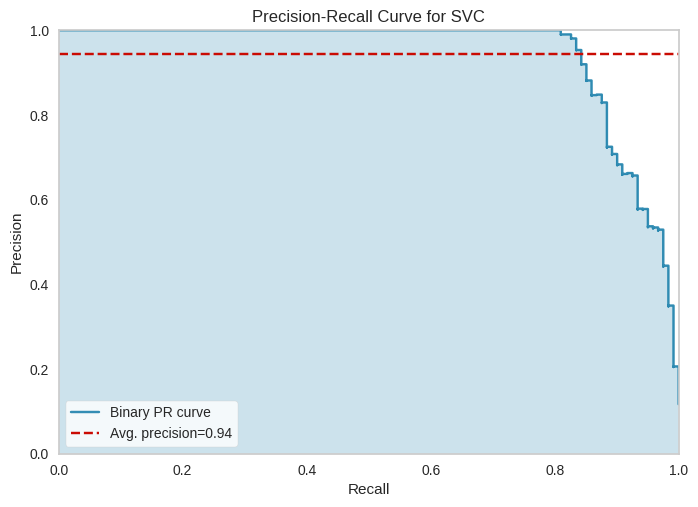

<Axes: title={'center': 'Precision-Recall Curve for SVC'}, xlabel='Recall', ylabel='Precision'>

In [152]:
prc_visualizer = PrecisionRecallCurve(svc)

prc_visualizer.fit(X_train, y_train)
prc_visualizer.score(X_test, y_test)
prc_visualizer.show()

##Случайный лес

In [125]:
random_forest = RandomForestClassifier(random_state=42)
start = time.time()
random_forest.fit(X_train,y_train)
end = time.time()
time_rf = end-start
y_pred = random_forest.predict(X_test)
accuracy_rf = accuracy_score(y_test, y_pred)
accuracy_rf

0.9729468599033816

In [126]:
print(classification_report(y_test, y_pred))

              precision    recall  f1-score   support

           0       0.97      1.00      0.98       914
           1       0.99      0.78      0.87       121

    accuracy                           0.97      1035
   macro avg       0.98      0.89      0.93      1035
weighted avg       0.97      0.97      0.97      1035



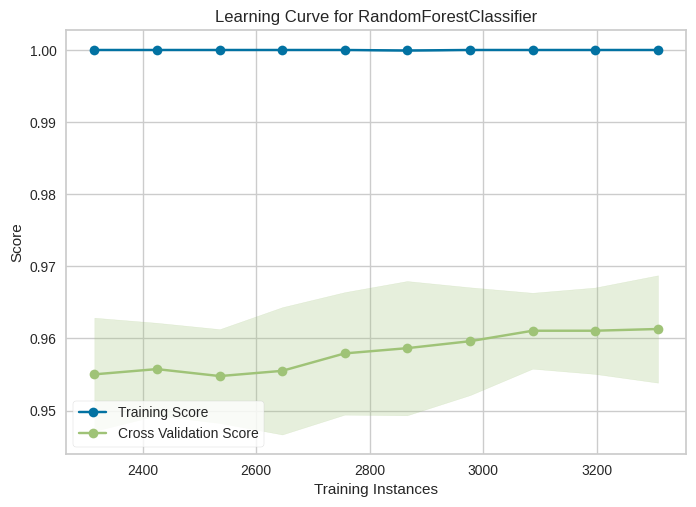

In [127]:
visualizer = LearningCurve(
    RandomForestClassifier(), scoring='accuracy', train_sizes=np.linspace(0.7, 1.0, 10)
).fit(X_train, y_train).show()

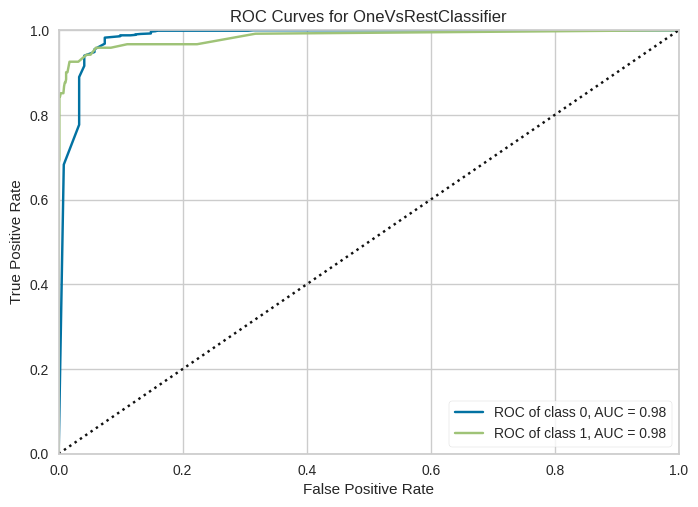

<Axes: title={'center': 'ROC Curves for OneVsRestClassifier'}, xlabel='False Positive Rate', ylabel='True Positive Rate'>

In [128]:
classifier = OneVsRestClassifier(RandomForestClassifier())

# Создаем объект для построения ROC-кривой
roc_auc_visualizer = ROCAUC(classifier, micro=False, macro=False, per_class=True)

#строим ROC-кривую
roc_auc_visualizer.fit(X_train, y_train)
roc_auc_visualizer.score(X_test, y_test)
roc_auc_visualizer.show()

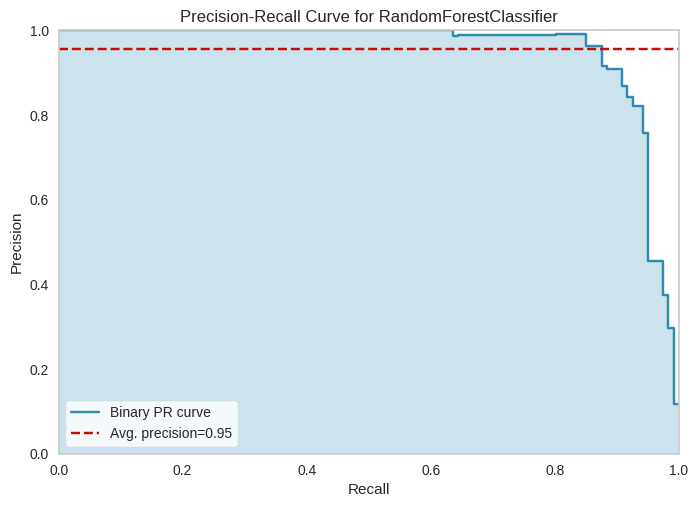

<Axes: title={'center': 'Precision-Recall Curve for RandomForestClassifier'}, xlabel='Recall', ylabel='Precision'>

In [129]:
prc_visualizer = PrecisionRecallCurve(random_forest)

prc_visualizer.fit(X_train, y_train)
prc_visualizer.score(X_test, y_test)
prc_visualizer.show()

## Метод k-ближайших соседей

In [130]:
k_neighbors = KNeighborsClassifier()
start = time.time()
k_neighbors.fit(X_train, y_train)
end = time.time()
time_kn = end-start

In [131]:
y_pred = k_neighbors.predict(X_test)
accuracy_kn = accuracy_score(y_test, y_pred)
accuracy_kn

0.9178743961352657

In [132]:
print(classification_report(y_test, y_pred))

              precision    recall  f1-score   support

           0       0.91      1.00      0.96       914
           1       1.00      0.30      0.46       121

    accuracy                           0.92      1035
   macro avg       0.96      0.65      0.71      1035
weighted avg       0.92      0.92      0.90      1035



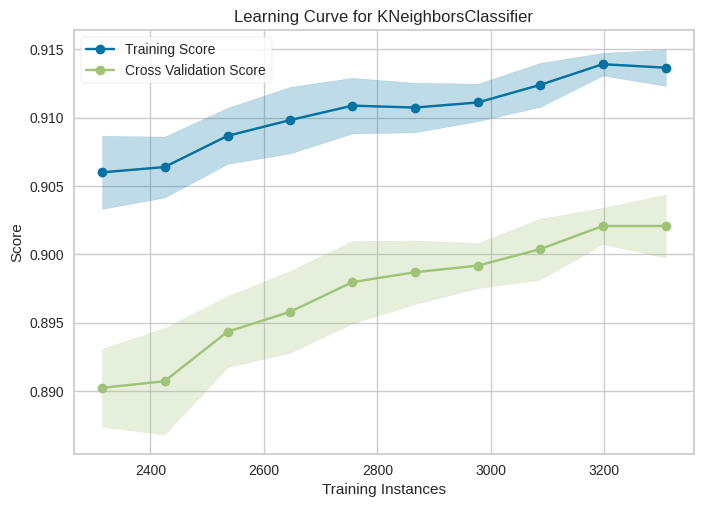

In [133]:
visualizer = LearningCurve(
   KNeighborsClassifier(), scoring='accuracy', train_sizes=np.linspace(0.7, 1.0, 10)
).fit(X_train, y_train).show()

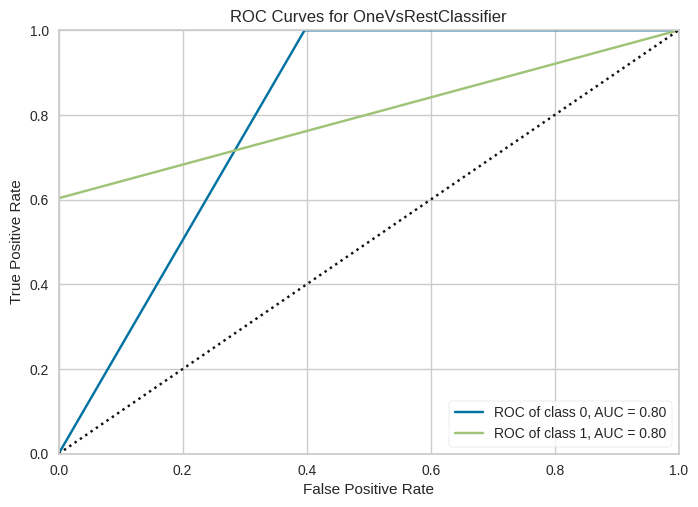

<Axes: title={'center': 'ROC Curves for OneVsRestClassifier'}, xlabel='False Positive Rate', ylabel='True Positive Rate'>

In [134]:
classifier = OneVsRestClassifier(KNeighborsClassifier())

# Создаем объект для построения ROC-кривой
roc_auc_visualizer = ROCAUC(classifier, micro=False, macro=False, per_class=True)

#строим ROC-кривую
roc_auc_visualizer.fit(X_train, y_train)
roc_auc_visualizer.score(X_test, y_test)
roc_auc_visualizer.show()

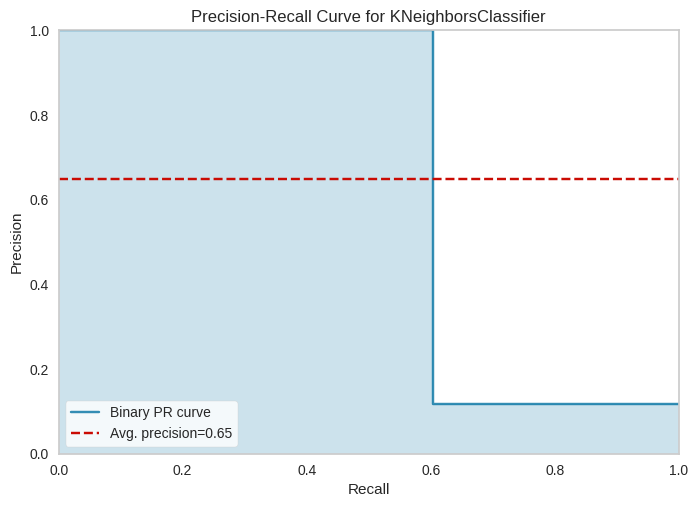

<Axes: title={'center': 'Precision-Recall Curve for KNeighborsClassifier'}, xlabel='Recall', ylabel='Precision'>

In [135]:
prc_visualizer = PrecisionRecallCurve(k_neighbors)

prc_visualizer.fit(X_train, y_train)
prc_visualizer.score(X_test, y_test)
prc_visualizer.show()

## Гребневой классификатор

In [136]:
ridge = RidgeClassifier()
start = time.time()
ridge.fit(X_train, y_train)
end = time.time()
time_rc = end-start

In [137]:
y_pred = ridge.predict(X_test)
accuracy_rc = accuracy_score(y_test, y_pred)
accuracy_rc

0.9797101449275363

In [138]:
print(classification_report(y_test, y_pred))

              precision    recall  f1-score   support

           0       0.98      1.00      0.99       914
           1       1.00      0.83      0.90       121

    accuracy                           0.98      1035
   macro avg       0.99      0.91      0.95      1035
weighted avg       0.98      0.98      0.98      1035



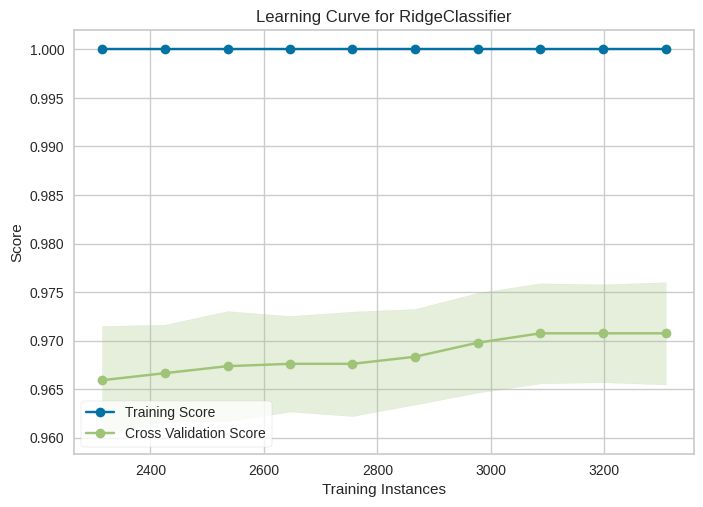

In [139]:
visualizer = LearningCurve(
   RidgeClassifier(), scoring='accuracy', train_sizes=np.linspace(0.7, 1.0, 10)
).fit(X_train, y_train).show()

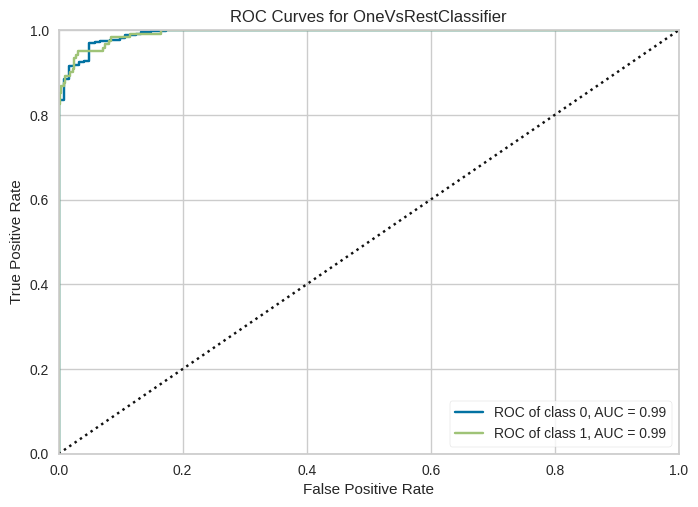

<Axes: title={'center': 'ROC Curves for OneVsRestClassifier'}, xlabel='False Positive Rate', ylabel='True Positive Rate'>

In [140]:
classifier = OneVsRestClassifier(RidgeClassifier())

# Создаем объект для построения ROC-кривой
roc_auc_visualizer = ROCAUC(classifier, micro=False, macro=False, per_class=True)

#строим ROC-кривую
roc_auc_visualizer.fit(X_train, y_train)
roc_auc_visualizer.score(X_test, y_test)
roc_auc_visualizer.show()

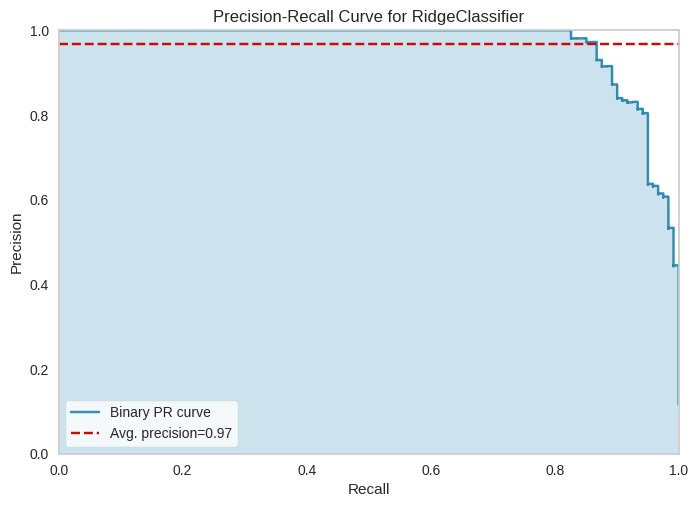

<Axes: title={'center': 'Precision-Recall Curve for RidgeClassifier'}, xlabel='Recall', ylabel='Precision'>

In [141]:
prc_visualizer = PrecisionRecallCurve(ridge)

prc_visualizer.fit(X_train, y_train)
prc_visualizer.score(X_test, y_test)
prc_visualizer.show()

## AdaBoostClassifier

In [142]:
adaboost = AdaBoostClassifier()
start = time.time()
adaboost.fit(X_train, y_train)
end = time.time()
time_adb = end-start

In [143]:
y_pred = adaboost.predict(X_test)
accuracy_adb = accuracy_score(y_test, y_pred)
accuracy_adb

0.966183574879227

In [144]:
print(classification_report(y_test, y_pred))

              precision    recall  f1-score   support

           0       0.97      0.99      0.98       914
           1       0.91      0.79      0.85       121

    accuracy                           0.97      1035
   macro avg       0.94      0.89      0.91      1035
weighted avg       0.97      0.97      0.97      1035



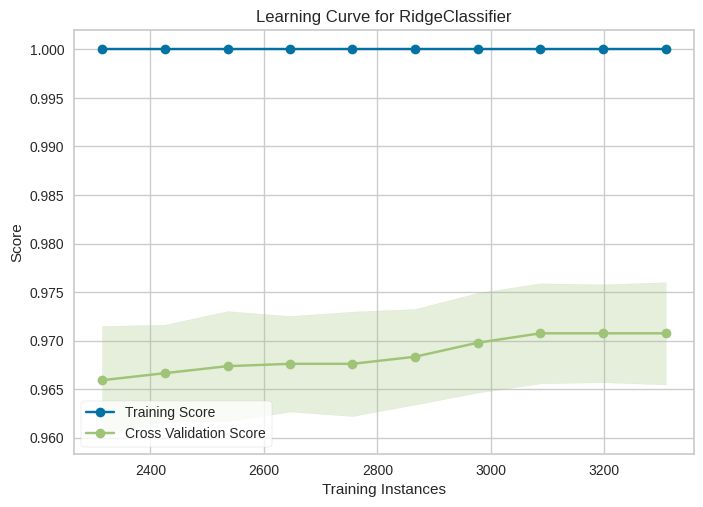

In [145]:
visualizer = LearningCurve(
   RidgeClassifier(), scoring='accuracy', train_sizes=np.linspace(0.7, 1.0, 10)
).fit(X_train, y_train).show()

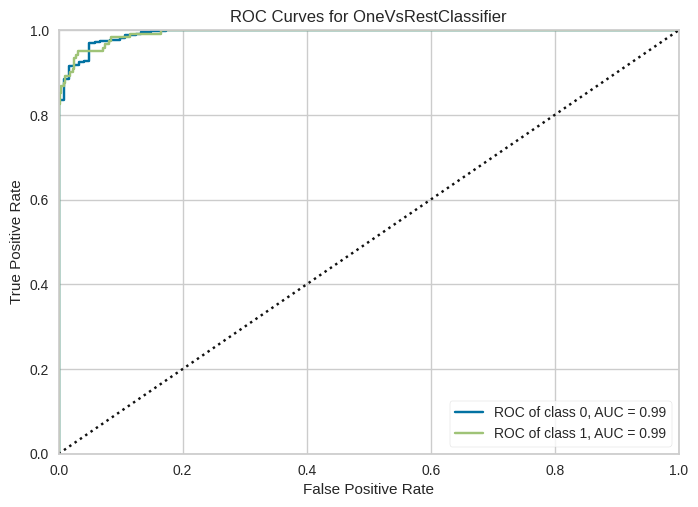

<Axes: title={'center': 'ROC Curves for OneVsRestClassifier'}, xlabel='False Positive Rate', ylabel='True Positive Rate'>

In [146]:
classifier = OneVsRestClassifier(RidgeClassifier())

# Создаем объект для построения ROC-кривой
roc_auc_visualizer = ROCAUC(classifier, micro=False, macro=False, per_class=True)

#строим ROC-кривую
roc_auc_visualizer.fit(X_train, y_train)
roc_auc_visualizer.score(X_test, y_test)
roc_auc_visualizer.show()

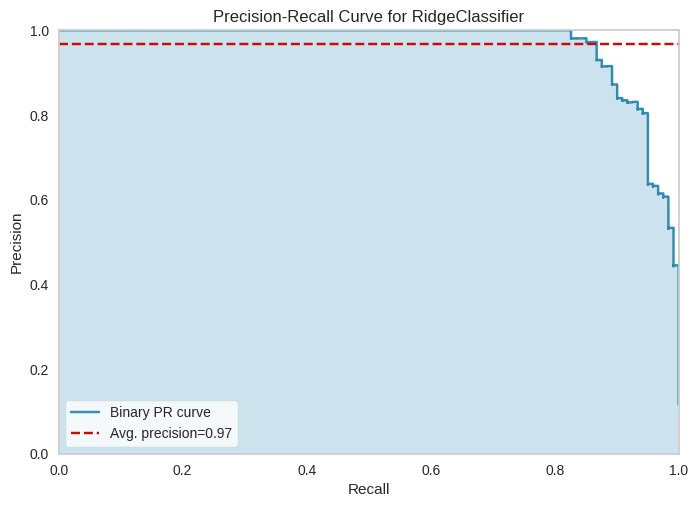

<Axes: title={'center': 'Precision-Recall Curve for RidgeClassifier'}, xlabel='Recall', ylabel='Precision'>

In [147]:
prc_visualizer = PrecisionRecallCurve(ridge)

prc_visualizer.fit(X_train, y_train)
prc_visualizer.score(X_test, y_test)
prc_visualizer.show()

#Сравнение моделей

In [61]:
def measure(name, y_test, y_test_pred):
  metrics = pd.DataFrame({
    name: [
        accuracy_score(y_test, y_test_pred),
        precision_score(y_test, y_test_pred),
        recall_score(y_test, y_test_pred),
        f1_score(y_test, y_test_pred),
    ],
  }, index = ["Accuracy", "Precision", "Recall", "F1"])
  return metrics

In [172]:
models = {
    "Multinomial Naive Bayes": MultinomialNB(),
    "Support Vector Machine": SVC(),
    "Random Forest": RandomForestClassifier(),
    "K-Nearest Neighbors": KNeighborsClassifier(),
    "Decision Tree": DecisionTreeClassifier(),
    "Ridge Classifier": RidgeClassifier(),
    "AdaBoostClassifier": AdaBoostClassifier()
}

for name, model in models.items():
    model.fit(X_train, y_train)
    y_pred = model.predict(X_test)
    print(measure(name, y_test, y_pred))

           Multinomial Naive Bayes
Accuracy                  0.973913
Precision                 0.856061
Recall                    0.933884
F1                        0.893281
           Support Vector Machine
Accuracy                 0.977778
Precision                1.000000
Recall                   0.809917
F1                       0.894977
           Random Forest
Accuracy        0.973913
Precision       0.989583
Recall          0.785124
F1              0.875576
           K-Nearest Neighbors
Accuracy              0.917874
Precision             1.000000
Recall                0.297521
F1                    0.458599
           Decision Tree
Accuracy        0.967150
Precision       0.899083
Recall          0.809917
F1              0.852174
           Ridge Classifier
Accuracy           0.979710
Precision          1.000000
Recall             0.826446
F1                 0.904977
           AdaBoostClassifier
Accuracy             0.966184
Precision            0.905660
Recall              

Поскольку мы имеем дело с несбалансированными классами, в нашем случае важно больше сравнивать метрики Precision и Recall, при этом учитывая Accuracy

In [63]:
time = pd.DataFrame({'модель':['DecisionTree', 'K-neghbors', 'Naive Bayes', 'Ridge Classifier',
                               'RandomForest', 'SVC', 'AdaBoost'],
                      'time':[time_dt,time_kn,time_nb,
                              time_rc,time_rf, time_svc, time_adb]})

time

,модель,time
0,DecisionTree,0.202463
1,K-neghbors,0.002224
2,Naive Bayes,0.008034
3,Ridge Classifier,0.046967
4,RandomForest,10.142246
5,SVC,0.784259
6,AdaBoost,2.282913


Выбирая наилучшую модель, мы сравниваем две модели с более хорошими метриками - Naive Bayes, Support Vector Machine, Ranom Forest и Ridge Classifier. У Байесовского классификатора лучше метрика Recall, что показывает, что модель более полно обнаруживает спам. Это важно для минимизации пропуска спама и обеспечения высокой степени обнаружения нежелательных сообщений. У гребневого классификатора, метода опорных векторов и случайного леса более высокая метрика Precision, что показывает, что модель более точно определяет спам. Это важно для предотвращения ложных срабатываний и ошибочного определения нормальных сообщений как спама. Для нашей задачи более значимо избежать ложных блокировок важных сообщений, исходя из этого наилучшая модель, у которой более высокая accuracy и precision и неплохие другие метрики, - RidgeClassifier.

#Анализ устойчивости модели. Изменение модели для её усовершенствования

Для оценки устойчивости модели к изменениям в данных, мы можем использовать метод кросс-валидации:

Применим Stratified валидацию, т.к. у нас несбалансированные классы

In [93]:
skf = StratifiedKFold(n_splits=3,shuffle=True, random_state=15)
skf.get_n_splits(X, Y)

3

In [94]:
skf.split(X,Y)

<generator object _BaseKFold.split at 0x7a0b488d5af0>

In [95]:
cv_results = cross_val_score(ridge,                  # модель
                             X,                      # матрица признаков
                             Y,                      # вектор цели
                             cv = skf,           # тип разбиения
                             scoring = 'accuracy',   # метрика
                             n_jobs=-1)              # используются все ядра CPU

print("Кросс-валидация: ", cv_results)
print("Среднее по кросс-валидации: ", cv_results.mean())

Кросс-валидация:  [0.97389791 0.97215777 0.97562391]
Среднее по кросс-валидации:  0.9738931987455107


Модель может быть применена в реальных условиях, так как точность модели на тестовом наборе данных
хорошая и близка к точности, полученной на кросс-валидации

RidgeClassifier - Классификатор, использующий гребневую регрессию.

Этот классификатор сначала преобразует целевые значения в {-1, 1}, а затем обрабатывает проблему как задачу регрессии.

Параметры модели:
alpha, fit_intercept,copy_X, max_iter, tol, class_weight, solver, positive, random_state

Выведем наилучшую модель

In [206]:
param_grid = {'alpha':[0.1,1,5,10,50,100], 'fit_intercept':[True, False], 'solver':['auto', 'svd', 'cholesky', 'lsqr', 'sparse_cg', 'sag', 'saga', 'lbfgs']}

In [207]:
grid_model = GridSearchCV(estimator=ridge,
                          param_grid=param_grid,
                          scoring='accuracy',
                          cv=5,
                          verbose=2)

In [208]:
grid_model.fit(X_train,y_train)

Fitting 5 folds for each of 96 candidates, totalling 480 fits
[CV] END .........alpha=0.1, fit_intercept=True, solver=auto; total time=   0.2s
[CV] END .........alpha=0.1, fit_intercept=True, solver=auto; total time=   0.2s
[CV] END .........alpha=0.1, fit_intercept=True, solver=auto; total time=   0.2s
[CV] END .........alpha=0.1, fit_intercept=True, solver=auto; total time=   0.2s
[CV] END .........alpha=0.1, fit_intercept=True, solver=auto; total time=   0.1s
[CV] END ..........alpha=0.1, fit_intercept=True, solver=svd; total time=   0.0s
[CV] END ..........alpha=0.1, fit_intercept=True, solver=svd; total time=   0.0s
[CV] END ..........alpha=0.1, fit_intercept=True, solver=svd; total time=   0.0s
[CV] END ..........alpha=0.1, fit_intercept=True, solver=svd; total time=   0.0s
[CV] END ..........alpha=0.1, fit_intercept=True, solver=svd; total time=   0.0s
[CV] END .....alpha=0.1, fit_intercept=True, solver=cholesky; total time=   0.0s
[CV] END .....alpha=0.1, fit_intercept=True, so

GridSearchCV(cv=5, estimator=RidgeClassifier(alpha=100000.0),
             param_grid={'alpha': [0.1, 1, 5, 10, 50, 100],
                         'fit_intercept': [True, False],
                         'solver': ['auto', 'svd', 'cholesky', 'lsqr',
                                    'sparse_cg', 'sag', 'saga', 'lbfgs']},
             scoring='accuracy', verbose=2)

In [188]:
grid_model.best_estimator_

RidgeClassifier(alpha=5)

Оптимальные параметры:

In [190]:
grid_model.best_params_

{'alpha': 5, 'fit_intercept': True, 'solver': 'auto'}

In [197]:
ridge_new = RidgeClassifier(alpha=5,fit_intercept=True, solver='auto')
ridge_new.fit(X_train, y_train)

RidgeClassifier(alpha=5)

In [198]:
y_pred = ridge_new.predict(X_test)
accuracy_rc_n = accuracy_score(y_test, y_pred)
pr_n = precision_score(y_test, y_pred),
rc_n = recall_score(y_test, y_pred),
f1_n = f1_score(y_test, y_pred)
accuracy_rc_n, pr_n, rc_n, f1_n

(0.9777777777777777, (1.0,), (0.8099173553719008,), 0.8949771689497716)

In [169]:
print(classification_report(y_test, y_pred))

              precision    recall  f1-score   support

           0       0.98      1.00      0.99       914
           1       1.00      0.81      0.89       121

    accuracy                           0.98      1035
   macro avg       0.99      0.90      0.94      1035
weighted avg       0.98      0.98      0.98      1035



В данной задаче классификации спама была проведена успешная работа, направленная на
разделение сообщений на два класса: спам и не спам. Результаты этой задачи имеют
важное значение для различных приложений-мессенджеров.
В ходе исследования были использованы следующие алгоритмы машинного обучения: Naive Bayes, DecisionTreeClassifier,Support Vector Machine,RandomForest,KNeighboors,RidgeClassifier, AdaBoostClassifier.     

Для каждого
алгоритма было оценено качество модели с помощью метрик accuracy, precision, recall, F1-score.
Было выявлено, что алгоритм RidgeClassifier показывает наилучшее качество, а K-Nearest Neighbors - наихудшее качество для данной задачи классификации спама.
Таким образом, результаты исследования показали, что машинное обучение может быть эффективно
использовано для классификации текстовых данных, в частности, для классификации
спам-сообщений. При этом выбор алгоритма машинного обучения имеет большое значение для достижения
высокого качества предсказания.